In [2]:
#Claes path
path = '/Users/claes/Documents/Mine dokumenter/Universitet/7.semester/Deep_learning/Final project/data/dataset/Revco/'

#Muhammed path
#path = '/Users/muhammadhussain/Desktop/Data/Revco/'

In [2]:
import pandas as pd

# Read the Parquet file into a DataFrame
df_temp = pd.read_parquet(path + '806265_temp.parquet')

# Display the first few rows
print(df_temp.head(5))

                 Datetime   RTD  1st Suc.  Cond. Air In  Evap. In  Evap. Out  \
index                                                                          
0     2013-01-16 11:31:13  19.5      11.6          11.8      16.3       15.8   
1     2013-01-16 11:31:33  19.5      11.6          11.8      16.3       15.7   
2     2013-01-16 11:32:33  19.5      11.7          11.7      16.3       15.8   
3     2013-01-16 11:33:34  19.5      11.6          11.7      16.3       15.7   
4     2013-01-16 11:34:33  19.5      11.6          11.8      16.3       15.7   

       2nd Suc.  Chil. water In  2nd Sump  H.E.  SetPoint  Mains Voltage  \
index                                                                      
0          11.9            11.5      12.7  12.7       -80          220.0   
1          11.9            11.5      12.1  12.1       -80          222.0   
2          11.9            11.5      12.3  12.0       -80          221.0   
3          11.9            11.5      12.0  11.8       -80  

In [7]:
# Read the Parquet file into a DataFrame
df_events = pd.read_parquet(path + '806271_events.parquet')

# Display the first few rows
#df_events.head(20)

In [2]:
pd.read_parquet(path + '806271_temp.parquet')
print(df.head(25))

                 Datetime   RTD  1st Suc.  Cond. Air In  Evap. In  Evap. Out  \
index                                                                          
898   2012-02-29 07:29:30 -70.2     -40.0          15.3     -87.0      -73.0   
899   2012-02-29 07:30:30 -71.4     -40.0          15.3     -87.0      -74.2   
900   2012-02-29 07:31:30 -72.5     -40.0          15.3     -87.0      -75.2   
901   2012-02-29 07:32:30 -74.0     -40.0          15.2     -87.0      -76.5   
902   2012-02-29 07:33:30 -75.5     -40.0          15.2     -87.0      -77.5   
903   2012-02-29 07:34:30 -76.6     -40.0          15.4     -87.0      -79.4   
904   2012-02-29 07:35:31 -78.0     -40.0          15.4     -87.0      -81.1   
905   2012-02-29 07:36:30 -79.0     -40.0          15.5     -87.0      -84.3   
906   2012-02-29 07:37:30 -80.0     -40.0          15.7     -87.0      -88.3   
907   2012-02-29 07:38:30 -83.0     -40.0          15.3     -87.0      -89.9   
908   2012-02-29 07:39:30 -84.0     -40.

In [12]:
import pandas as pd

path = '/Users/claes/Documents/Mine dokumenter/Universitet/7.semester/Deep_learning/Final project/data/dataset/Revco/'

Freezer_number = 806279

# Parameters
days_before_event = 3
days_after_event = 3

RTD_higher_than = -70
voltage_lower_than = 200

remove_from_date = '2019-04-01'
remove_until_date = '2019-08-01'

# Load your Parquet file
df = pd.read_parquet(path + str(Freezer_number) + '_temp.parquet')

# Ensure 'Datetime' is in datetime format
df['Datetime'] = pd.to_datetime(df['Datetime'])

# **Step 1**: Filter out rows based on RTD and Mains Voltage
df = df[(df['RTD'] <= RTD_higher_than) & (df['Mains Voltage'] >= voltage_lower_than)]

# **Step 2**: Remove rows between dates
df = df[~((df['Datetime'] >= remove_from_date) & (df['Datetime'] <= remove_until_date))]

# **Step 3**: Identify the indices where an event has occurred
event_indices = df[df['Event'].notnull()].index

# Set to collect indices for rows to keep in the time window
indices_to_collect = set()

# Loop through each event
for idx in event_indices:
    # Get the event timestamp and value
    event_time = df.loc[idx, 'Datetime']
    event_value = df.loc[idx, 'Event']
    
    # Ensure Event is a scalar or a string
    if isinstance(event_value, list):
        event_value = ', '.join(event_value)
    
    # Define the time window
    start_time = event_time - pd.Timedelta(days=days_before_event)
    end_time = event_time + pd.Timedelta(days=days_after_event)
    
    # Select rows within the time window
    mask = (df['Datetime'] >= start_time) & (df['Datetime'] <= end_time)
    window_indices = df[mask].index
    
    # Assign the event value
    df.loc[window_indices, 'Event'] = event_value
    indices_to_collect.update(window_indices)

# Filter out rows in the time window (if needed)
df_around_events = df.loc[list(indices_to_collect)].copy()  # Data within the time window
df_cleaned = df.drop(indices_to_collect)  # Remove these rows from the main DataFrame

# **Step 6**: Save both DataFrames
#df_around_events.to_parquet(path + 'around_events_data_' + str(Freezer_number) + '.parquet', index=False)
df_cleaned.to_parquet(path + 'cleaned_data_' + str(Freezer_number) + '.parquet', index=False)

In [6]:
pd.read_parquet('/Users/muhammadhussain/Desktop/Data/filter/cleaned_data_806283.parquet')

,Datetime,RTD,1st Suc.,Cond. Air In,Evap. In,Evap. Out,2nd Suc.,Chil. water In,2nd Sump,H.E.,SetPoint,Mains Voltage,State,Type,Event,main_fault
0,2013-01-17 00:13:20,-70.2,-29.7,16.6,-83.2,-75.5,-43.4,-127.0,54.2,-36.7,-86,223.0,3,None,None,None
1,2013-01-17 00:14:20,-71.2,-29.7,16.5,-83.5,-77.5,-44.0,-127.0,54.1,-36.7,-86,223.5,3,None,None,None
2,2013-01-17 00:15:20,-72.2,-30.3,16.4,-83.4,-77.9,-44.5,-127.0,54.0,-36.8,-86,223.2,3,None,None,None
3,2013-01-17 00:16:20,-73.2,-30.4,16.3,-83.5,-78.9,-45.0,-127.0,53.8,-36.8,-86,222.3,3,None,None,None
4,2013-01-17 00:17:20,-73.9,-30.1,16.3,-83.6,-79.7,-45.6,-127.0,53.7,-36.8,-86,220.2,3,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4700661,2023-04-01 00:51:20,-80.8,-32.8,19.5,-63.6,-81.2,-25.2,7.1,31.1,-37.5,-80,225.7,0,None,None,None
4700662,2023-04-01 00:52:20,-80.6,-24.8,19.5,-61.6,-80.5,-19.7,6.0,32.1,-32.7,-80,225.7,0,None,None,None
4700663,2023-04-01 00:53:20,-80.3,-19.3,19.5,-60.9,-80.2,-15.0,7.9,33.0,-30.2,-80,226.0,0,None,None,None
4700664,2023-04-01 00:54:20,-80.2,-15.7,19.6,-61.3,-79.9,-11.2,9.7,33.5,-29.2,-80,226.2,0,None,None,None


In [ ]:
df = pd.read_parquet(path + str(Freezer_number) + '_temp.parquet')

# Calculate the number of rows in each DataFrame
total_rows = len(df)
rows_around_events = len(df_around_events)
rows_cleaned = len(df_cleaned)

# Calculate the percentage of rows moved to df_around_events
percentage_removed = (rows_around_events / total_rows) * 100

# Print the results
print(f"Total rows in original DataFrame: {total_rows:,}")
print(f"Rows in df_around_events: {rows_around_events:,}")
print(f"Rows in df_cleaned: {rows_cleaned:,}")
print(f"Percentage of rows removed to df_around_events: {percentage_removed:.2f}%")

Total rows in original DataFrame: 5,104,342
Rows in df_around_events: 0
Rows in df_cleaned: 3,408,860
Percentage of rows removed to df_around_events: 0.00%


### Show around_events_data

In [27]:
# Read the Parquet file into a DataFrame
df_temp = pd.read_parquet(str(path) + '/around_events_data_' + str(Freezer_number) + '.parquet')

pd.set_option('display.max_rows', None)

# Display the first few rows
#df_temp.head(10000)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/muhammadhussain/Desktop/Data/Revco//around_events_data_806276.parquet'

### Show only rows with events

In [9]:
import pandas as pd

df = pd.read_parquet(path + '806265_temp.parquet')

pd.set_option('display.max_rows', None)

df_filtered = df[df['Event'].notnull()]
#df_filtered.head(500)
#print(df_filtered.head(5))

### Amount events pr type

In [10]:
import pandas as pd

# Ensure the 'Event' column is not null
df_events = df[df['Event'].notnull()]

# If the 'Event' column contains byte strings, decode them
df_events['Event'] = df_events['Event'].apply(
    lambda x: x.decode('utf-8') if isinstance(x, bytes) else x
)

# Count the occurrences of each unique event
event_counts = df_events['Event'].value_counts()

# Display the counts
print(event_counts)

Event
["Door is opened"]                                                                                                                               259
["Display Power On"]                                                                                                                              32
["Shutdown"]                                                                                                                                      28
["AC Power Interrupted"]                                                                                                                          25
["AC Power Restored"]                                                                                                                             23
["AC Power Interrupted","AC Power Restored"]                                                                                                      23
["Door is opened","Door closed after  min= 0 sec= 8"]                                               

/var/folders/ly/_w65sdvd4_j8scqw644db_nr0000gn/T/ipykernel_6656/3757052721.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_events['Event'] = df_events['Event'].apply(


In [11]:
import pandas as pd

# Ensure the 'Event' column is not null
df_events = df.loc[df['Event'].notnull()]

# Decode byte strings, if any, to UTF-8
df_events.loc[:, 'Event'] = df_events['Event'].apply(
    lambda x: x.decode('utf-8') if isinstance(x, bytes) else x
)

# Ensure all values in 'Event' column are strings
df_events['Event'] = df_events['Event'].astype(str)

# Filter out rows containing "Door is opened" or "Door closed"
filtered_df = df_events.loc[~df_events['Event'].str.contains(r"Door is opened|Door closed", regex=True, na=False)]

# Count the occurrences of each remaining unique event
event_counts = filtered_df['Event'].value_counts()

# Display the counts
print(event_counts)

Event
["Display Power On"]                                                                                                   32
["Shutdown"]                                                                                                           28
["AC Power Interrupted"]                                                                                               25
["AC Power Interrupted","AC Power Restored"]                                                                           23
["AC Power Restored"]                                                                                                  23
["Sensor value out of range - TC9"]                                                                                    20
["Display Power On","Sensor value out of range - TC9"]                                                                 13
["Replace Main Battery"]                                                                                               12
["Warm Alarm has b

/var/folders/ly/_w65sdvd4_j8scqw644db_nr0000gn/T/ipykernel_6656/3179882390.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_events['Event'] = df_events['Event'].astype(str)


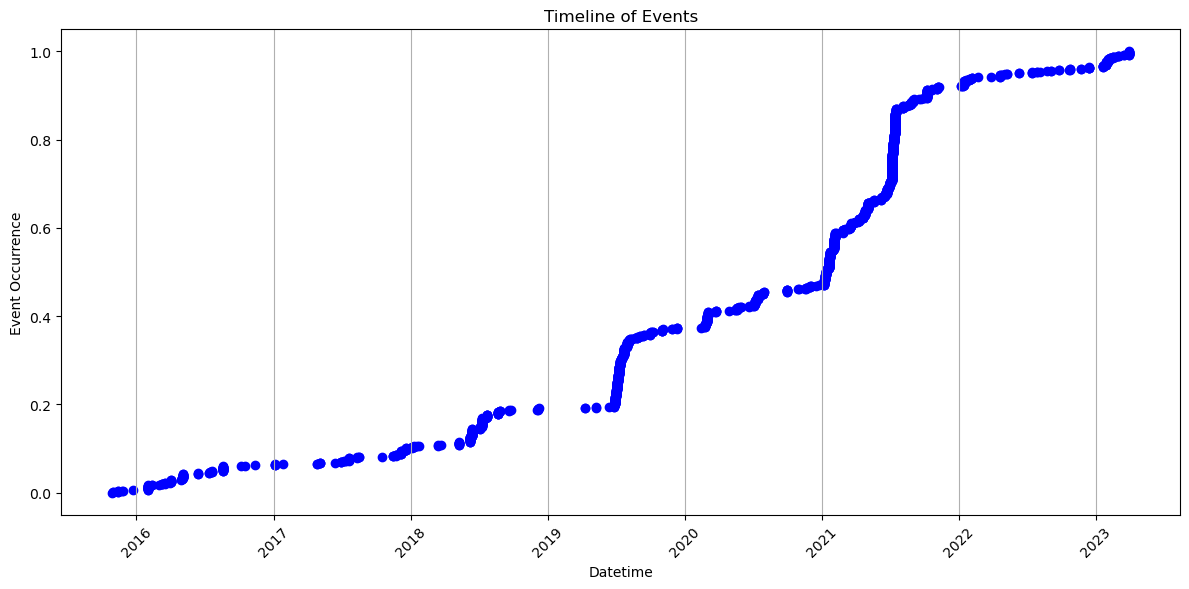

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Ensure the 'Datetime' column is in datetime format
df['Datetime'] = pd.to_datetime(df['Datetime'])

# Filter rows where 'Event' is not 'None'
df_events = df[df['Event'].notnull()]

# Sort the DataFrame by 'Datetime'
df_events = df_events.sort_values(by='Datetime')

# Create a y-axis position for each event to spread them out
# We'll alternate the y-axis position to avoid overlap
num_events = len(df_events)
y_positions = np.linspace(0, 1, num_events)  # Spread y-values slightly above and below 1

plt.figure(figsize=(12, 6))
plt.scatter(df_events['Datetime'], y_positions, marker='o', color='blue')

# # Add event descriptions as annotations with offsets
# for i, (idx, row) in enumerate(df_events.iterrows()):
#     plt.annotate(
#         row['Event'].decode('utf-8') if isinstance(row['Event'], bytes) else row['Event'],
#         (row['Datetime'], y_positions[i]),
#         textcoords="offset points",
#         xytext=(0, 10),
#         ha='center',
#         fontsize=9,
#         arrowprops=dict(arrowstyle='->', color='gray', lw=0.5)
#     )

# Formatting the plot
plt.title('Timeline of Events')
plt.xlabel('Datetime')
plt.ylabel('Event Occurrence')
plt.grid(axis='x')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Clean data plotted on raw data

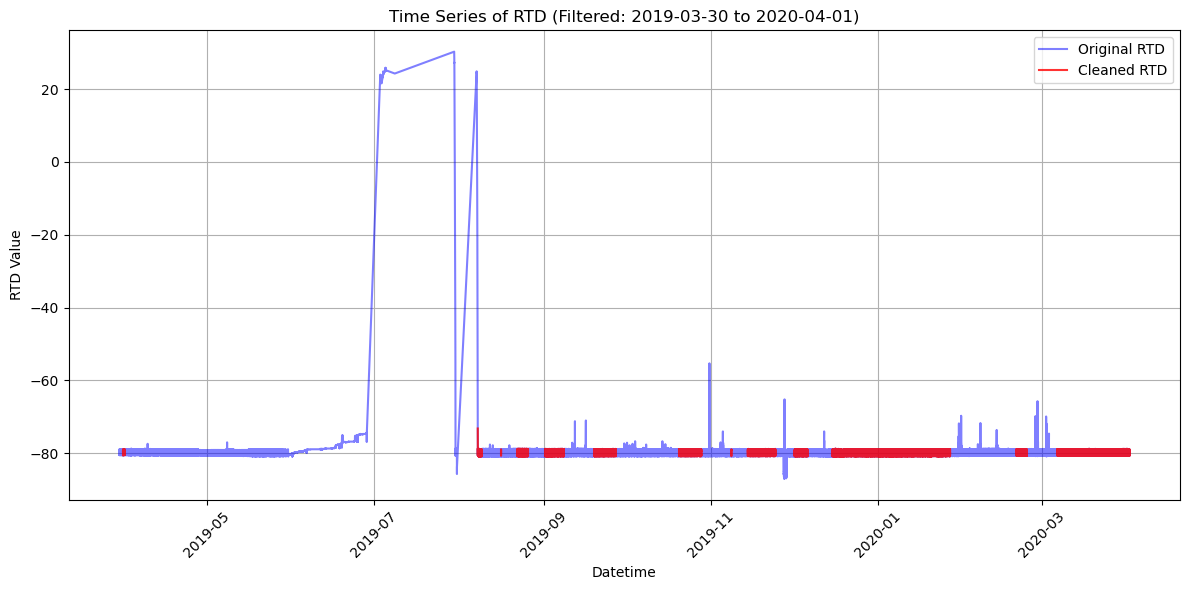

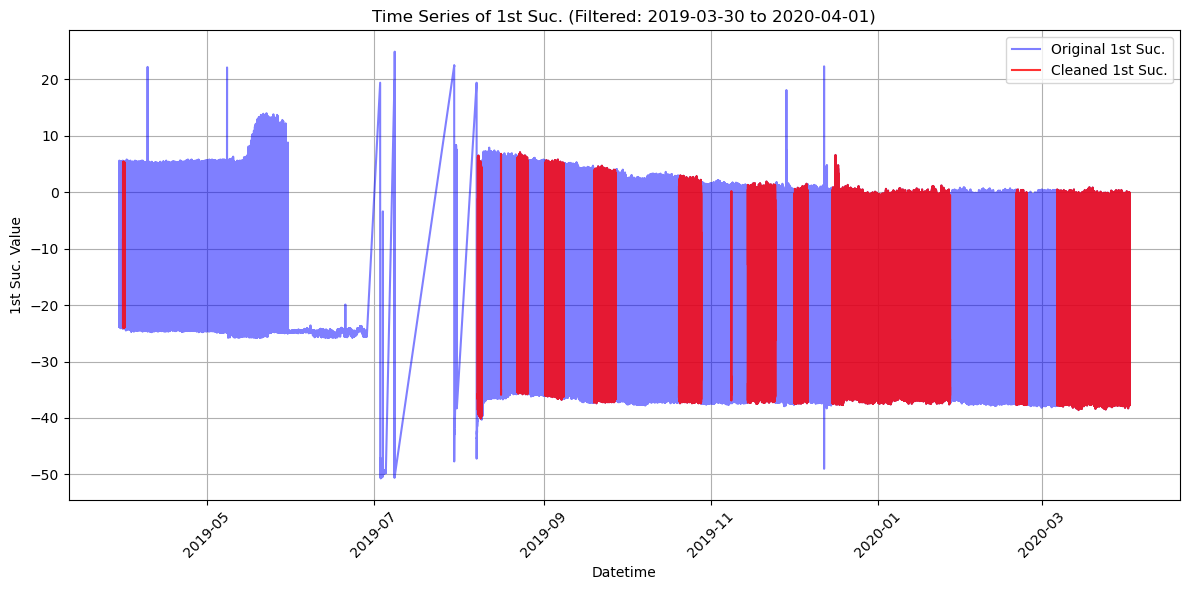

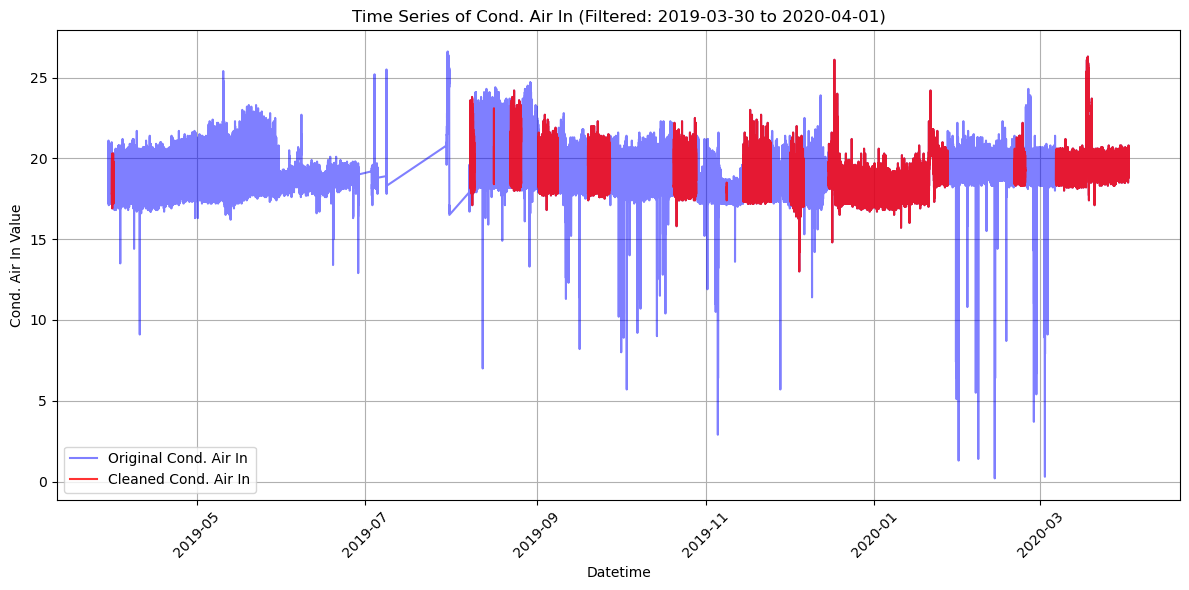

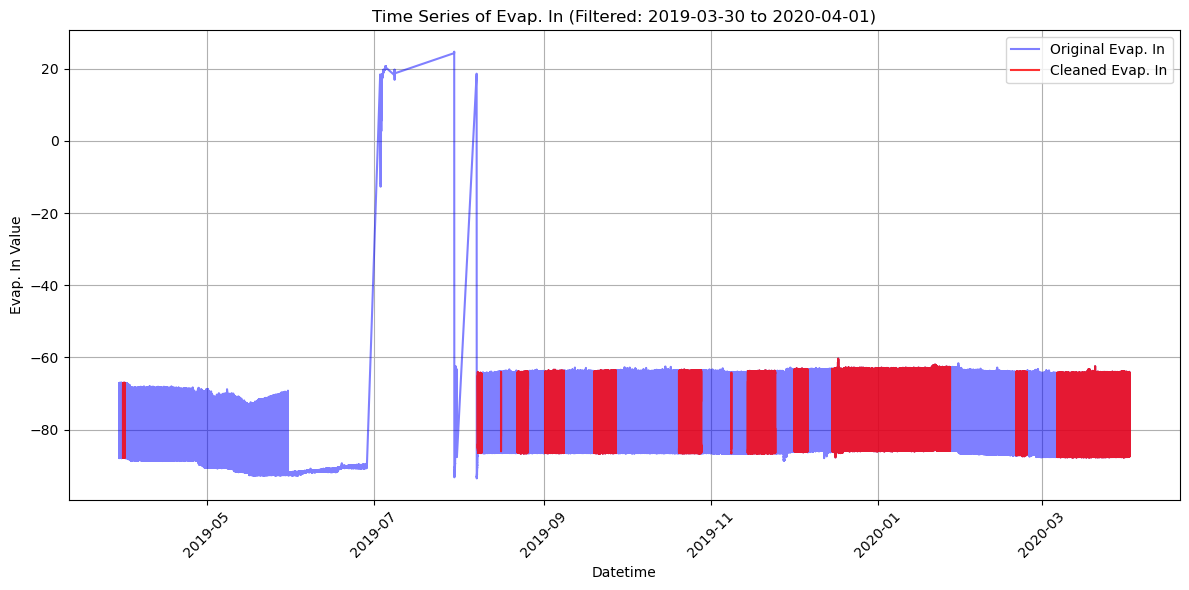

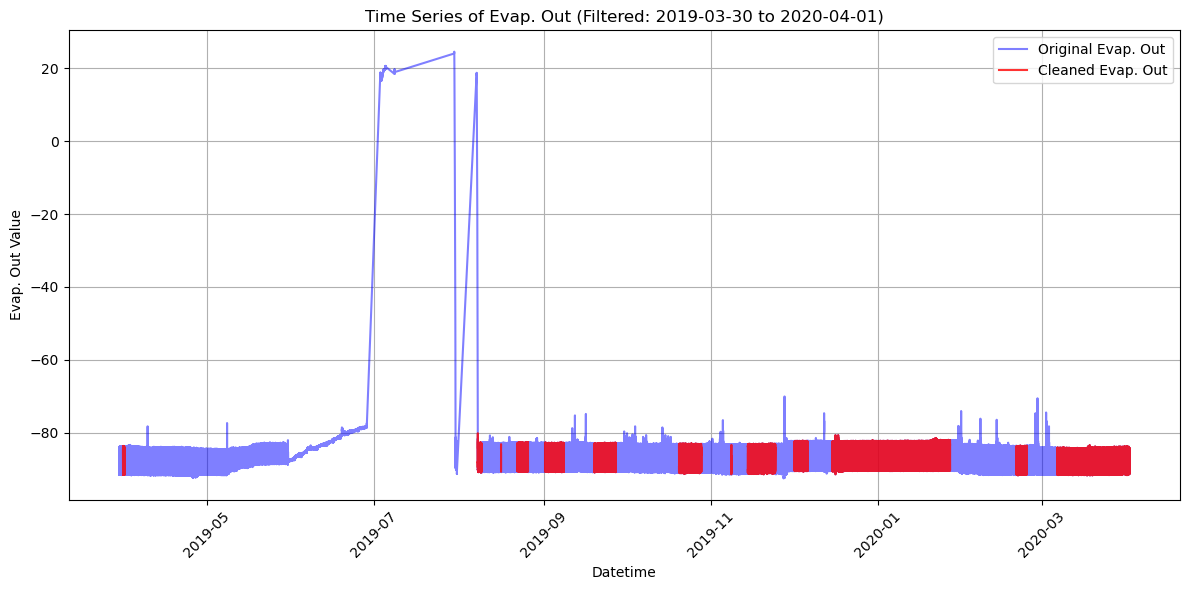

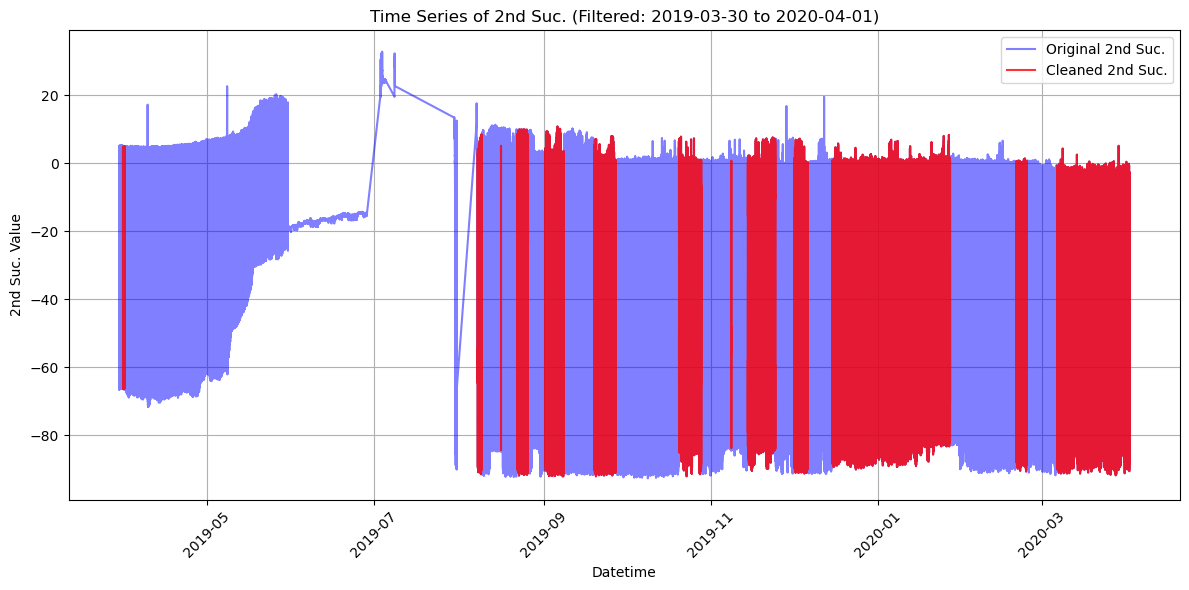

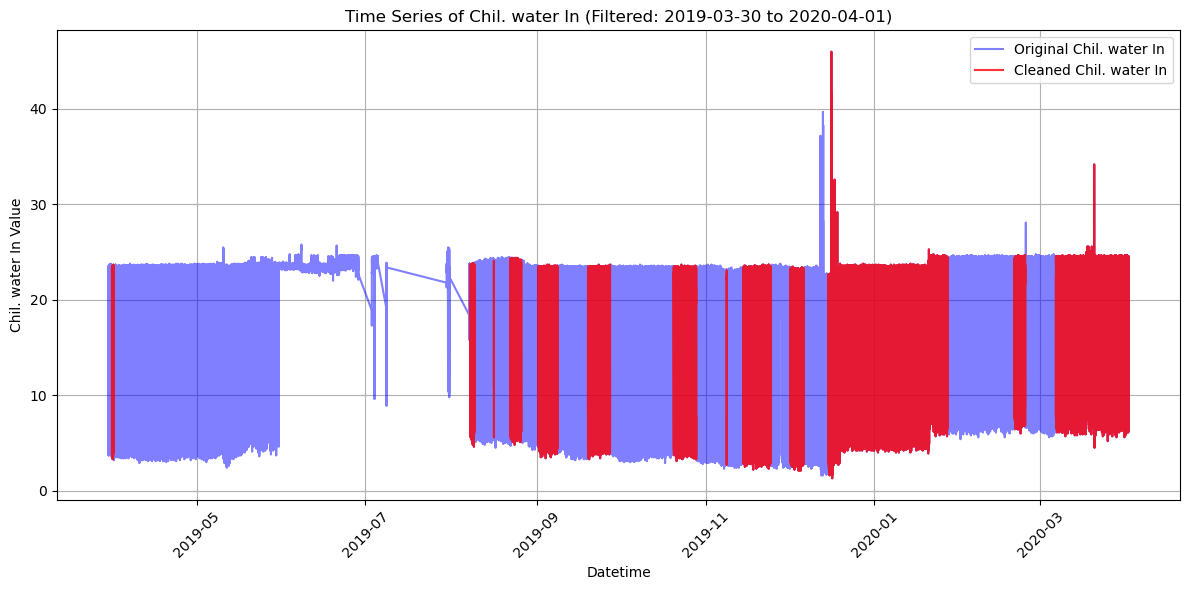

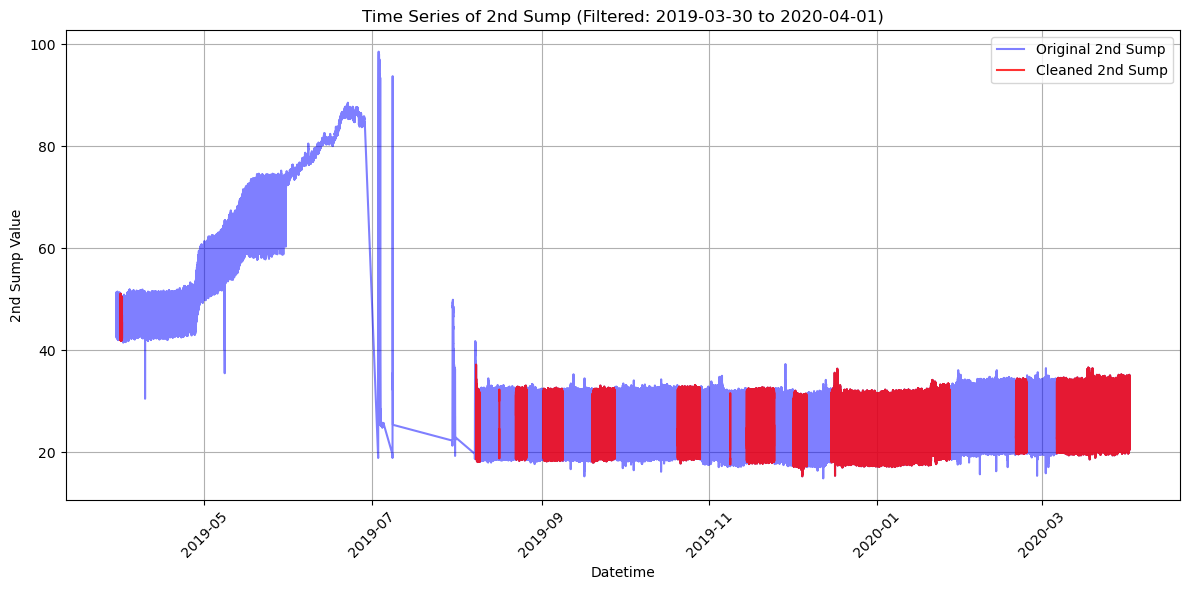

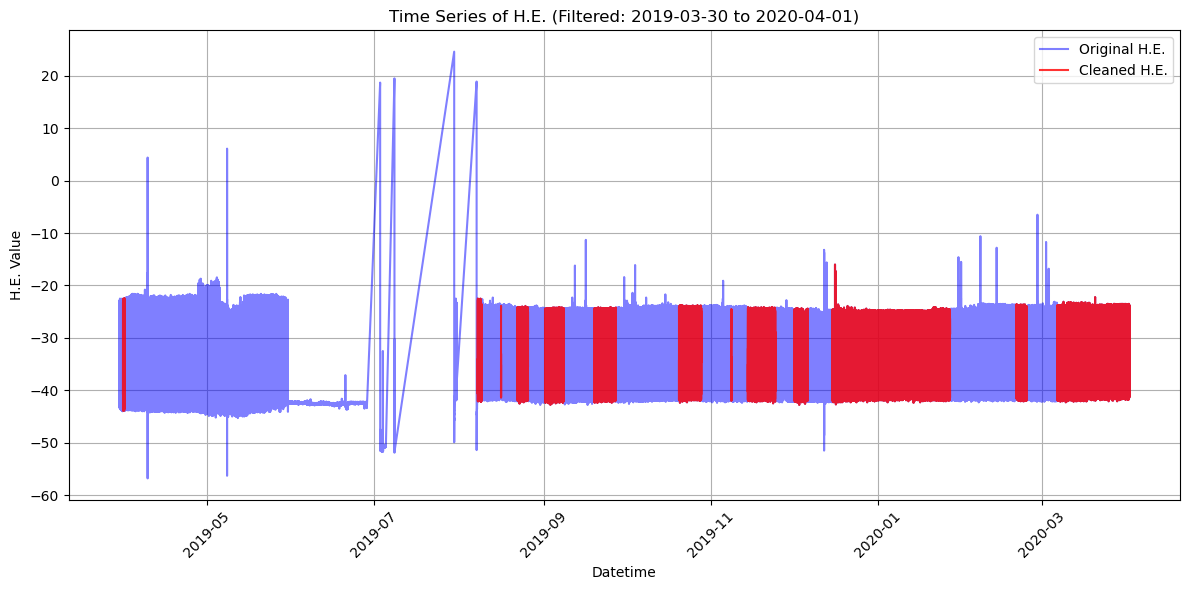

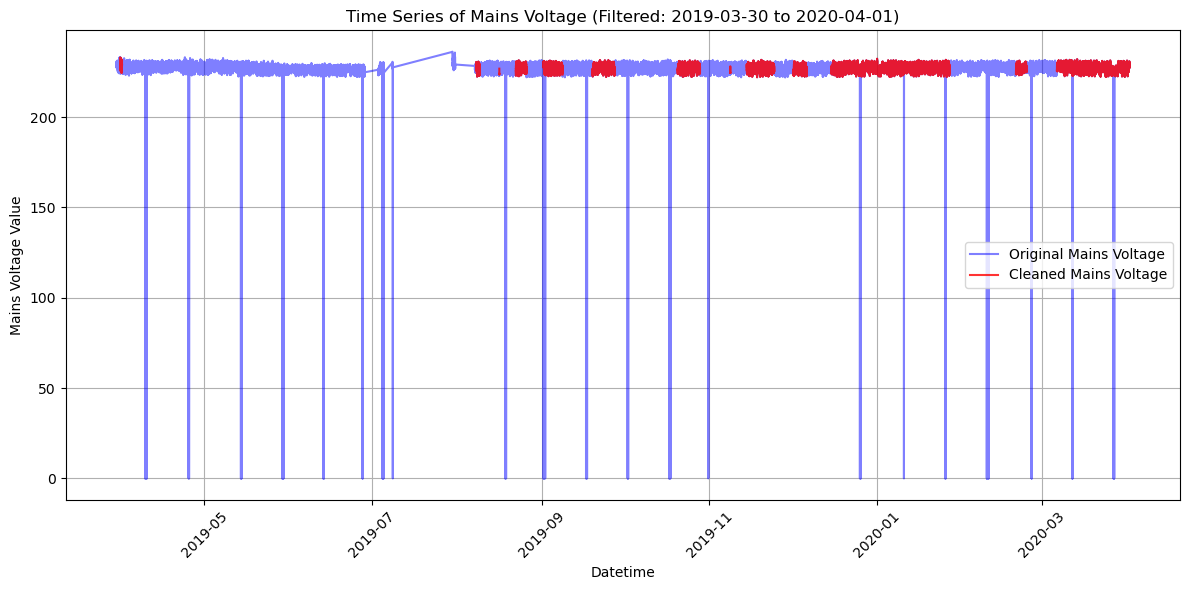

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

#Freezer_number = 806016

# Parameters
start_date = '2019-03-30'
end_date = '2020-04-01'

#start_date = '2017-09-30'
#end_date = '2018-10-01'

# Read the original and cleaned Parquet files into DataFrames
df_original = pd.read_parquet(path + str(Freezer_number) + '_temp.parquet')
df_cleaned = pd.read_parquet(path + 'cleaned_data_' + str(Freezer_number) + '.parquet')

# Convert 'Datetime' to datetime type if not already done
df_original['Datetime'] = pd.to_datetime(df_original['Datetime'])
df_cleaned['Datetime'] = pd.to_datetime(df_cleaned['Datetime'])

# Set 'Datetime' as the index for easier plotting
df_original.set_index('Datetime', inplace=True)
df_cleaned.set_index('Datetime', inplace=True)

# Filter both DataFrames to the specified date range
df_original_filtered = df_original.loc[start_date:end_date]
df_cleaned_filtered = df_cleaned.loc[start_date:end_date]

# Select only numeric columns for plotting (assuming both DataFrames have the same structure)
numeric_columns = df_cleaned_filtered.select_dtypes(include=['float64', 'int64']).columns

# Calculate time differences for the cleaned data to detect gaps
time_diffs = df_cleaned_filtered.index.to_series().diff().dt.total_seconds()

# Define a threshold (e.g., 2x the median difference) to detect large gaps
gap_threshold = 2 * time_diffs.median()

# Insert NaNs where gaps are detected in the cleaned data
df_cleaned_filtered.loc[time_diffs > gap_threshold, numeric_columns] = np.nan

# Plot each numeric column, overlaying cleaned data (red) on original data (blue)
for col in numeric_columns:
    plt.figure(figsize=(12, 6))
    
    # Plot original data in blue
    plt.plot(df_original_filtered.index, df_original_filtered[col], label=f'Original {col}', color='blue', alpha=0.5)
    
    # Plot cleaned data in red
    plt.plot(df_cleaned_filtered.index, df_cleaned_filtered[col], label=f'Cleaned {col}', color='red', alpha=0.8)
    
    # Customize plot appearance
    plt.title(f"Time Series of {col} (Filtered: {start_date} to {end_date})")
    plt.xlabel("Datetime")
    plt.ylabel(f"{col} Value")
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.legend()
    plt.show()

## Clean data

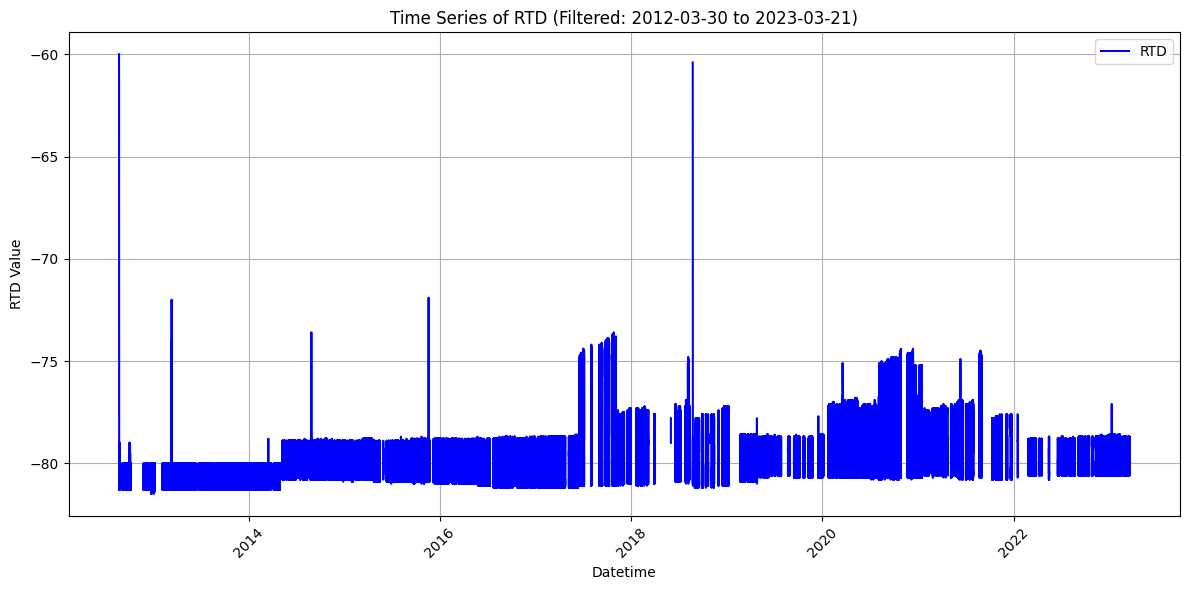

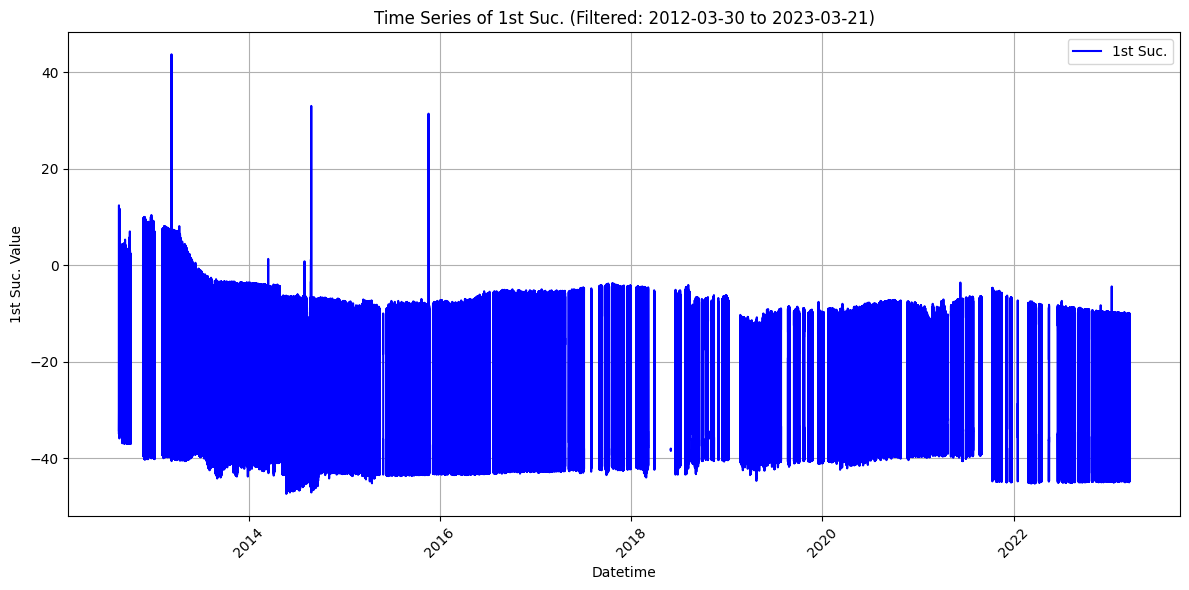

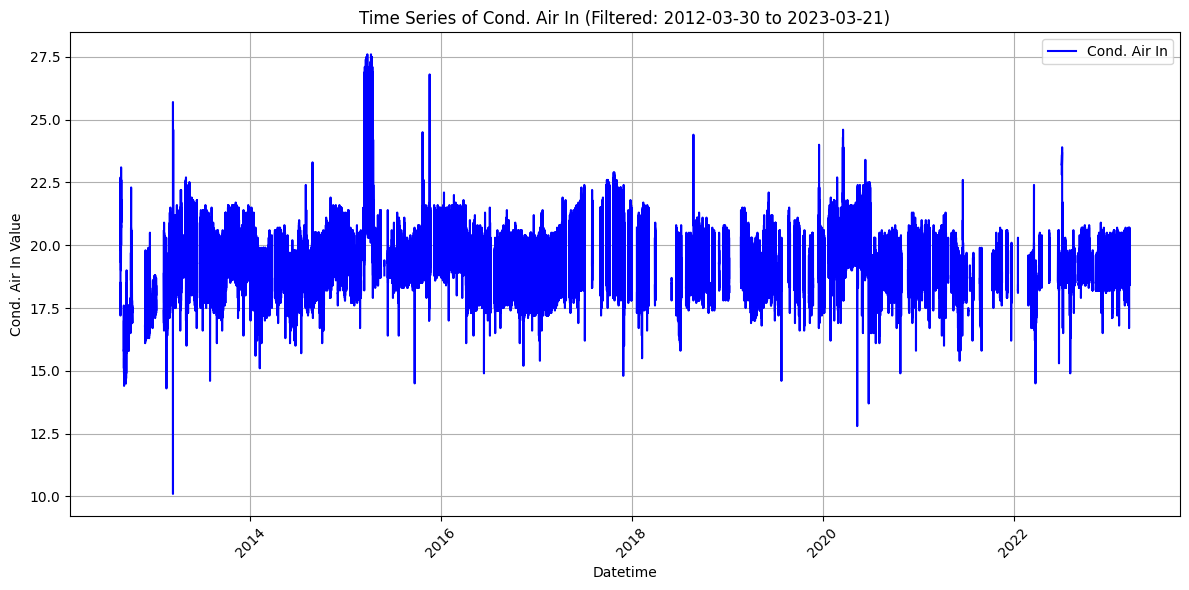

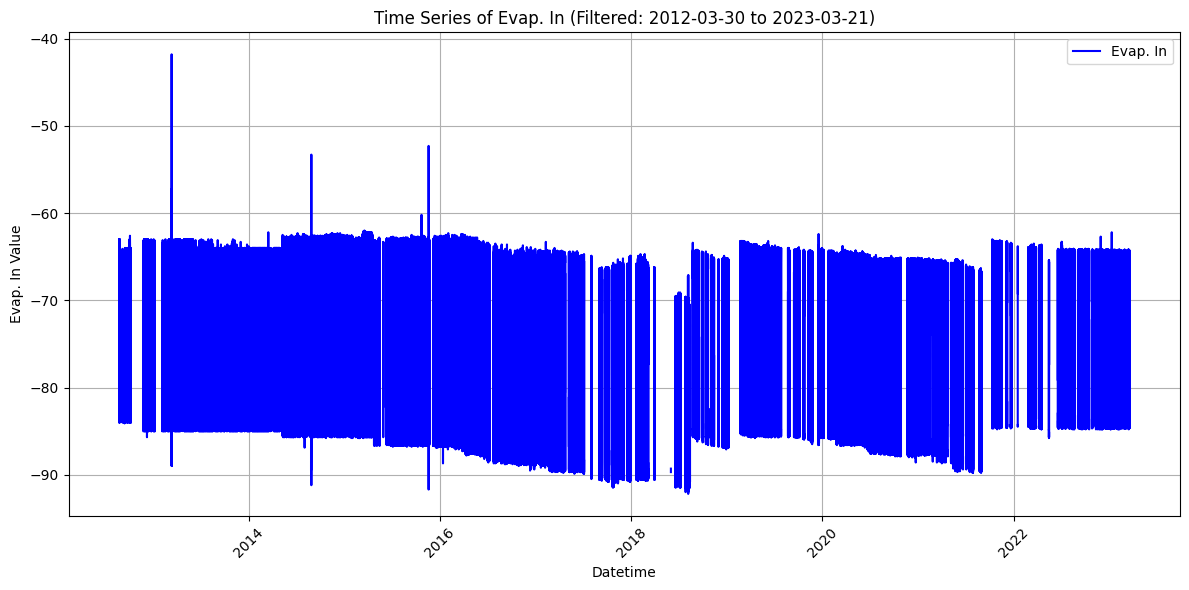

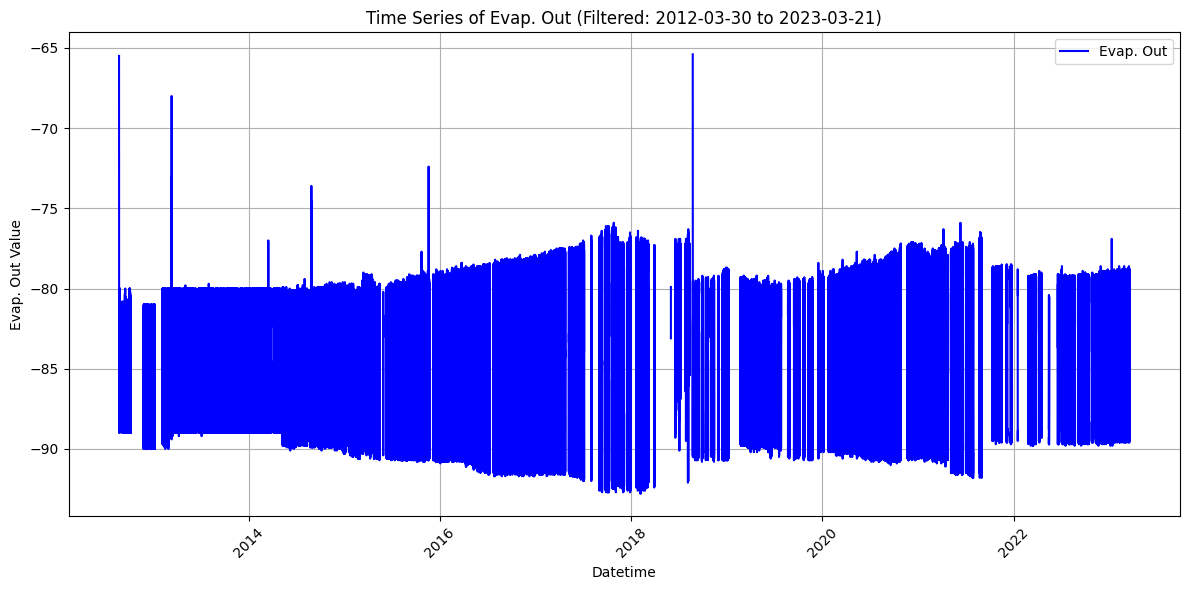

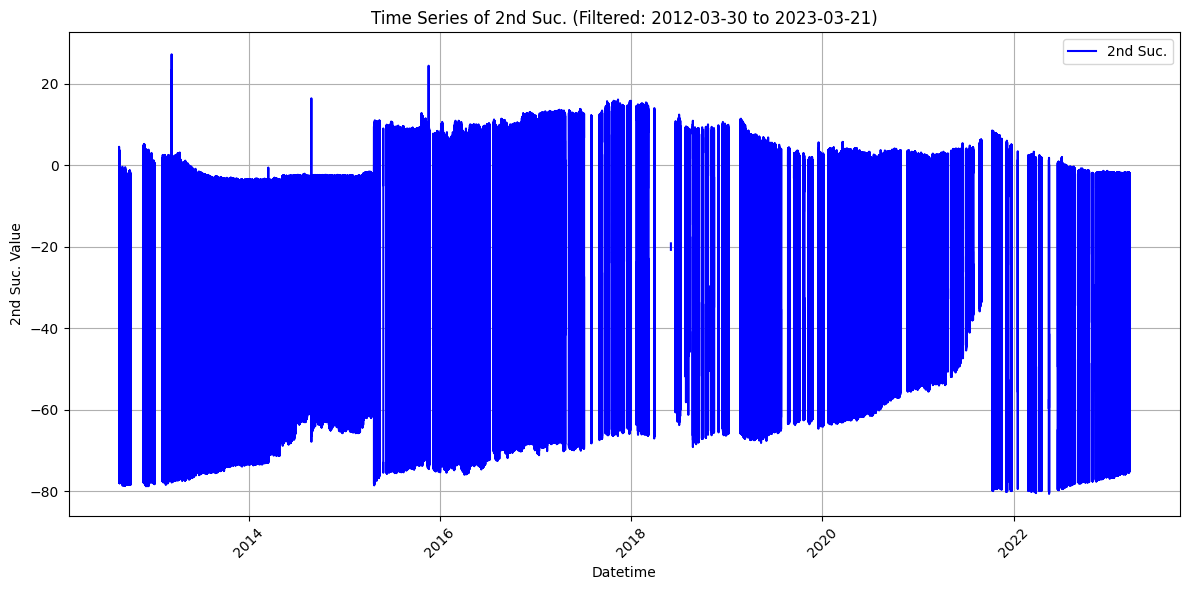

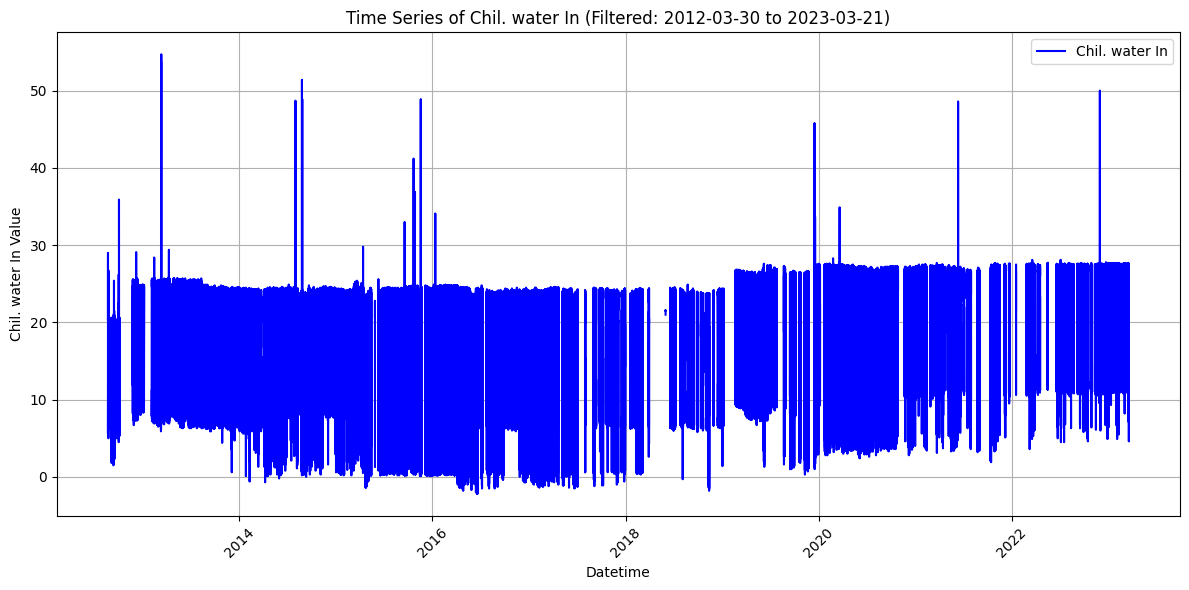

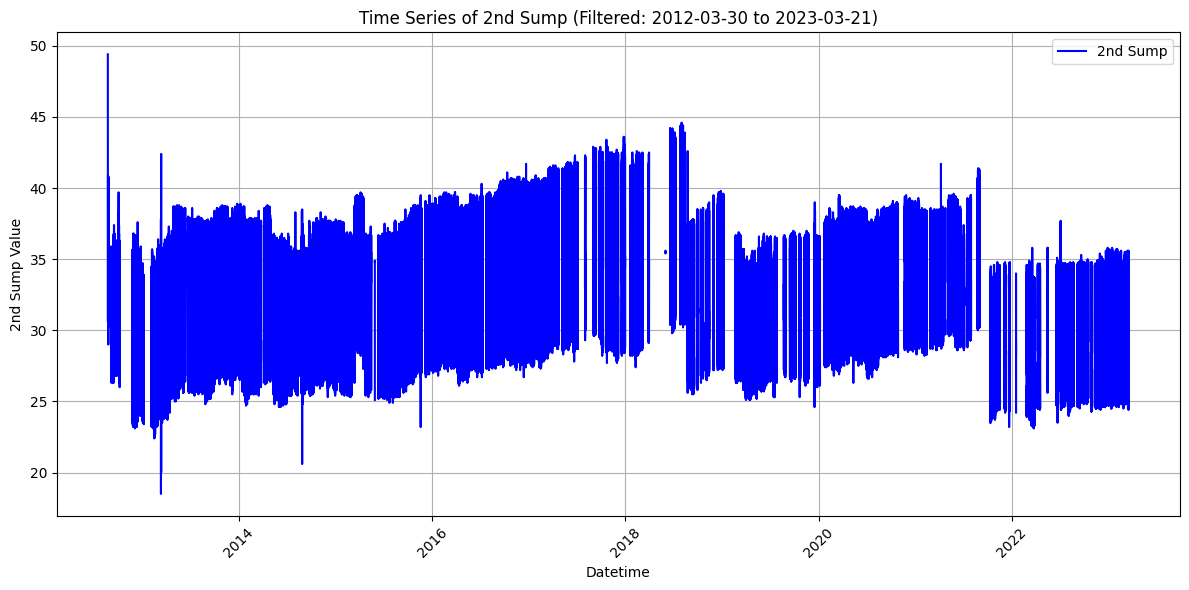

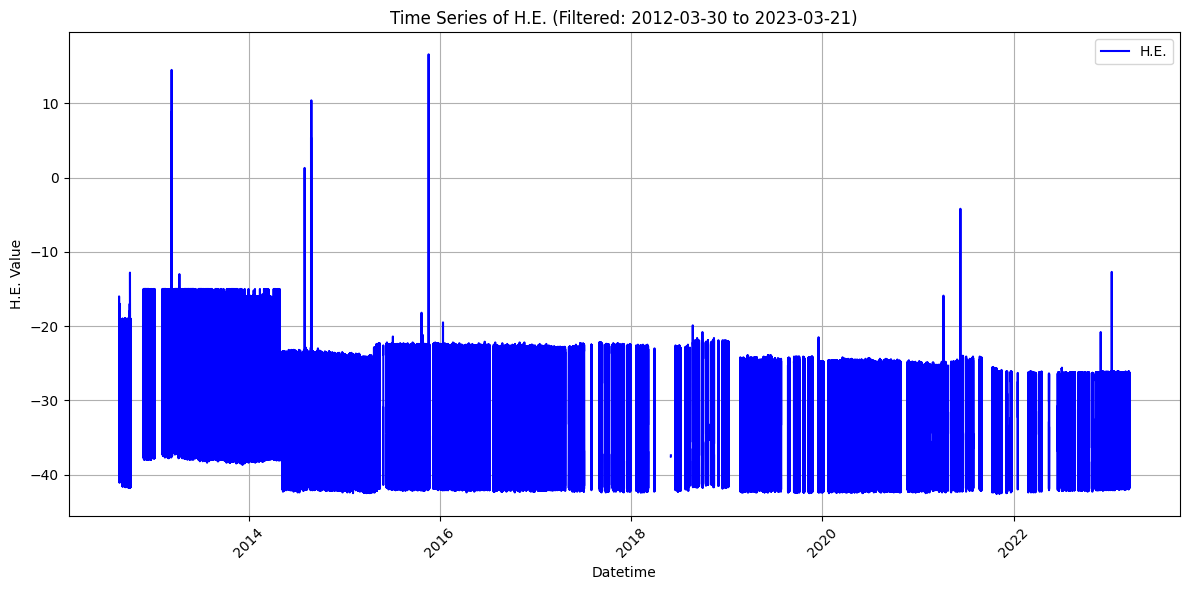

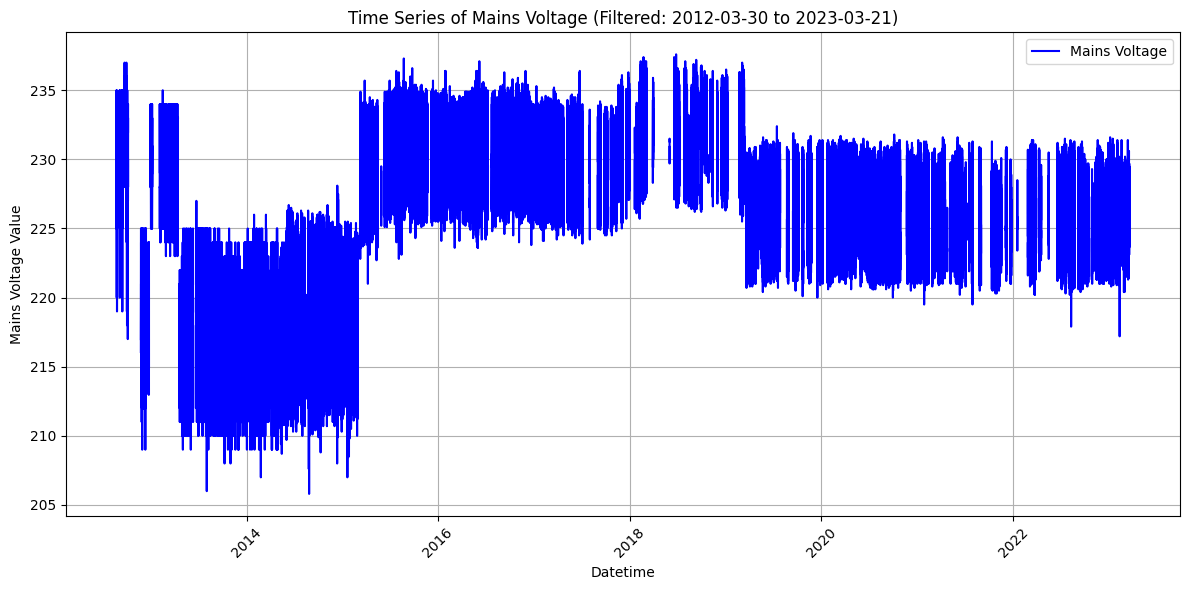

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Parameters
start_date = '2012-03-30'
end_date = '2023-03-21'

# Read the cleaned Parquet file into a DataFrame
df = pd.read_parquet(path + 'cleaned_data_' + str(Freezer_number) + '.parquet')

# Convert 'Datetime' to datetime type if it's not already
df['Datetime'] = pd.to_datetime(df['Datetime'])

# Set 'Datetime' as the index for easier plotting
df.set_index('Datetime', inplace=True)

# Filter the DataFrame to the specified date range
df_filtered = df.loc[start_date:end_date]

# Select only numeric columns for plotting
numeric_columns = df_filtered.select_dtypes(include=['float64', 'int64']).columns

# Calculate time differences between consecutive rows
time_diffs = df_filtered.index.to_series().diff().dt.total_seconds()

# Define a threshold (e.g., 2x the median difference) to detect large gaps
gap_threshold = 2 * time_diffs.median()

# Insert NaNs where gaps are detected
df_filtered.loc[time_diffs > gap_threshold, numeric_columns] = np.nan

# Plot each numeric column separately
for col in numeric_columns:
    plt.figure(figsize=(12, 6))
    plt.plot(df_filtered.index, df_filtered[col], label=col, color='blue')
    
    plt.title(f"Time Series of {col} (Filtered: {start_date} to {end_date})")
    plt.xlabel("Datetime")
    plt.ylabel(f"{col} Value")
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.legend()
    plt.show()

## Raw data

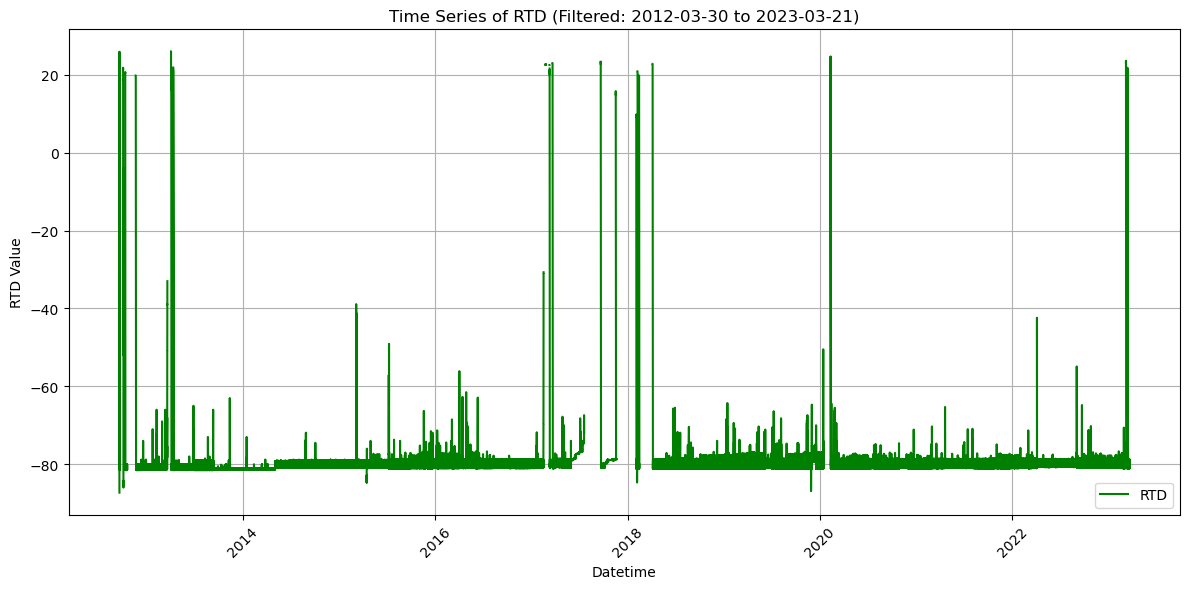

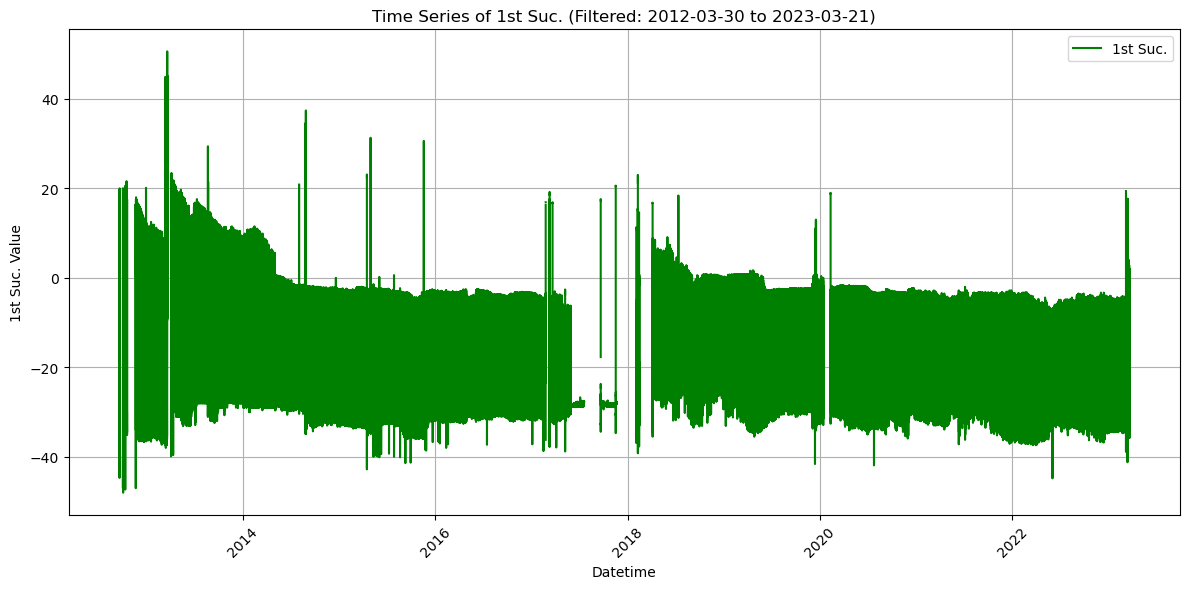

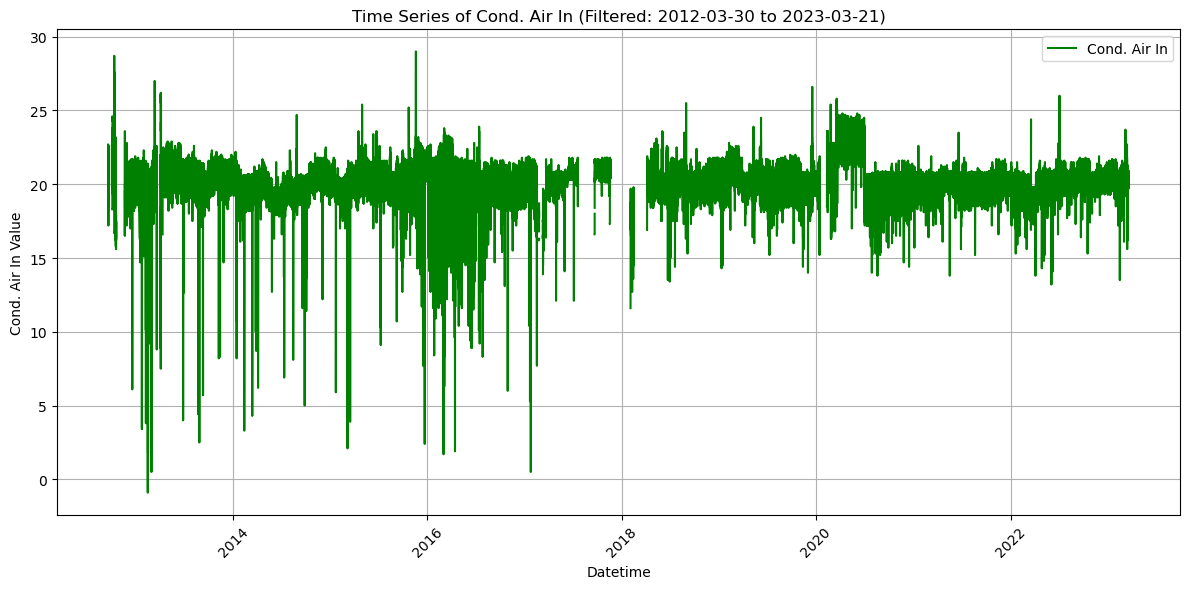

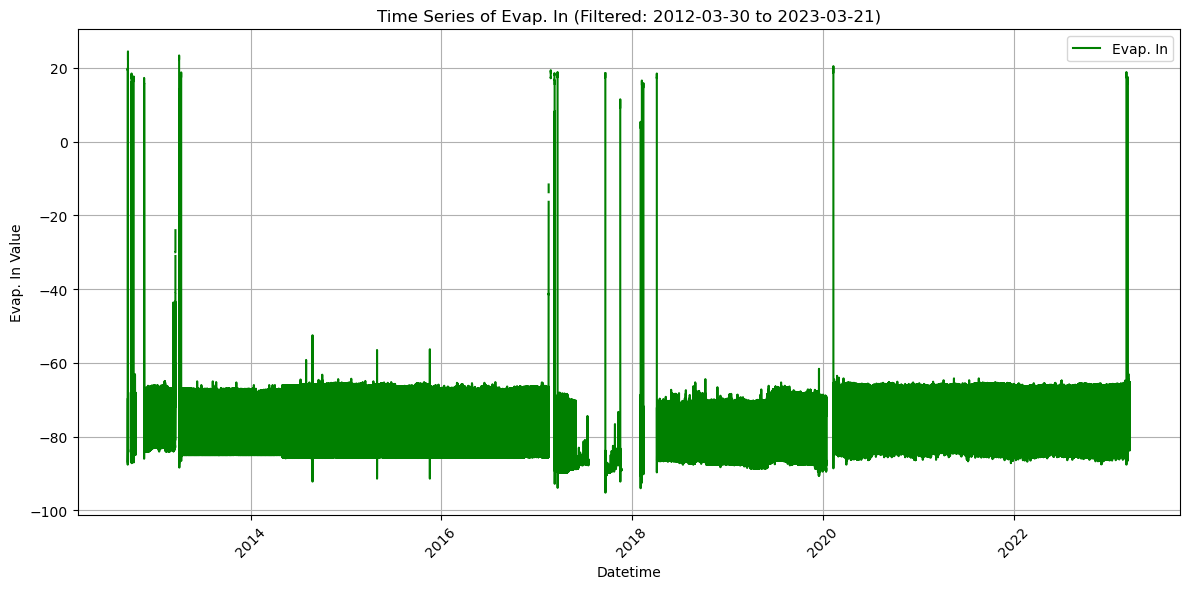

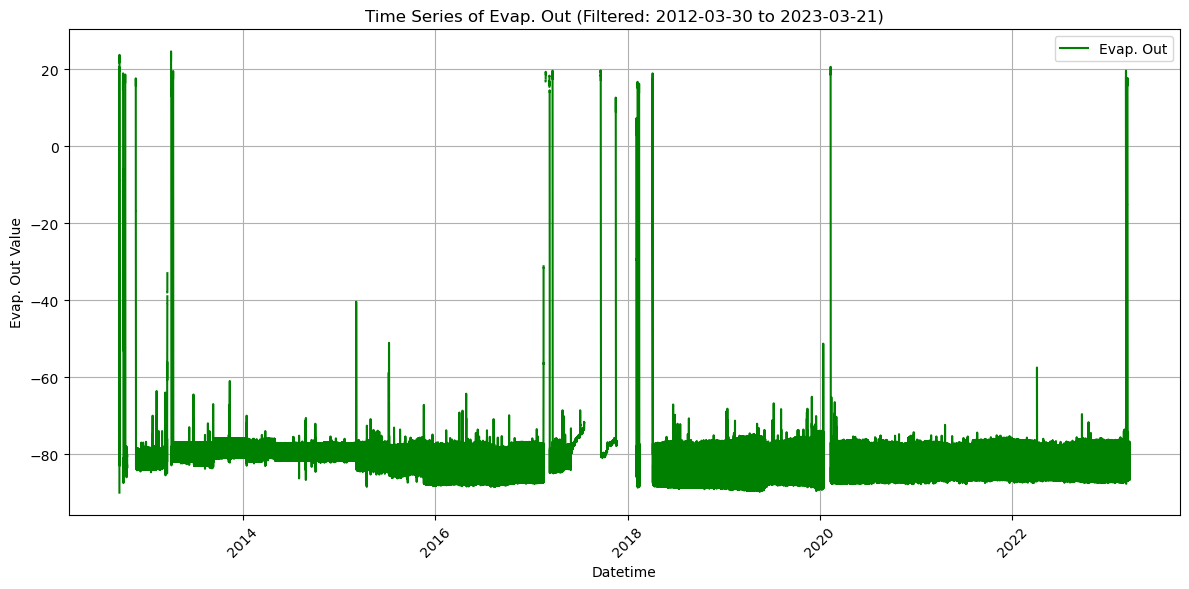

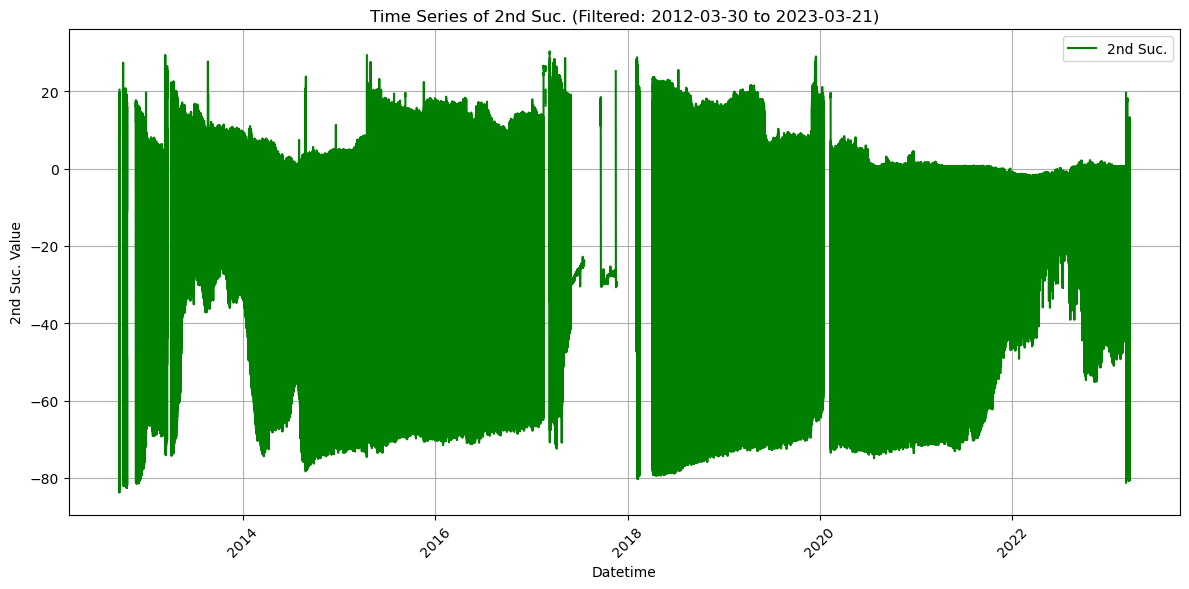

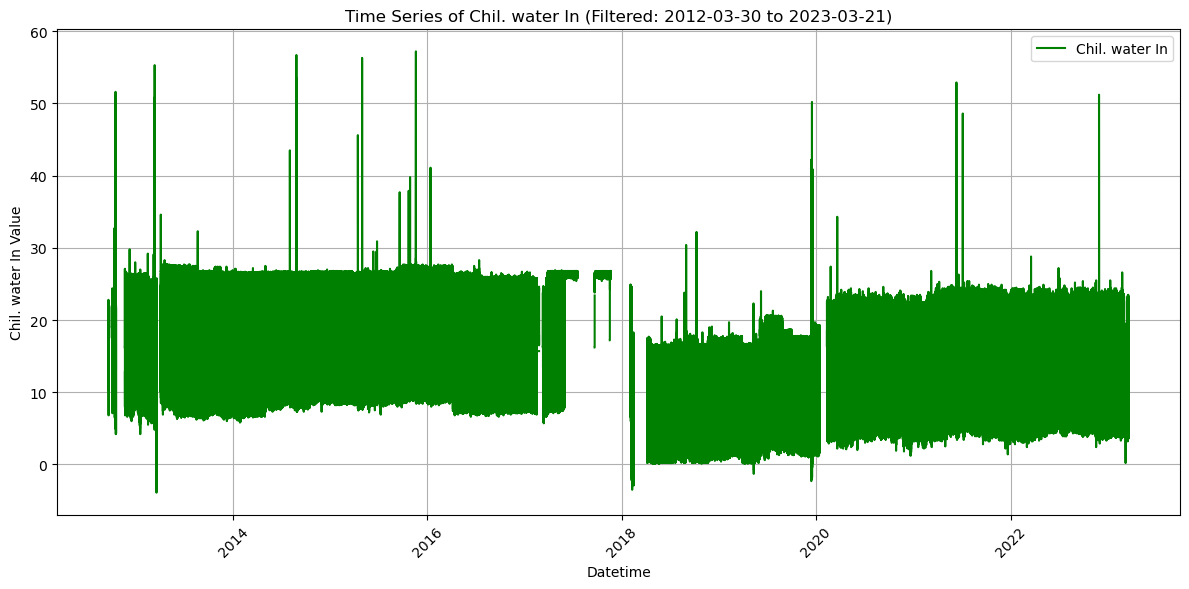

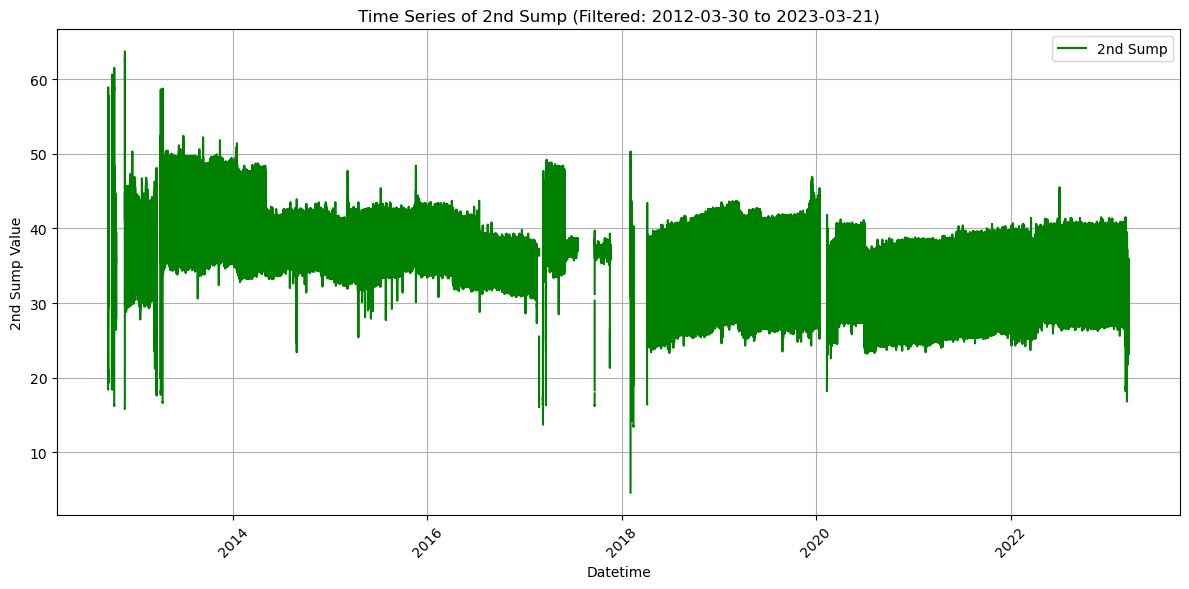

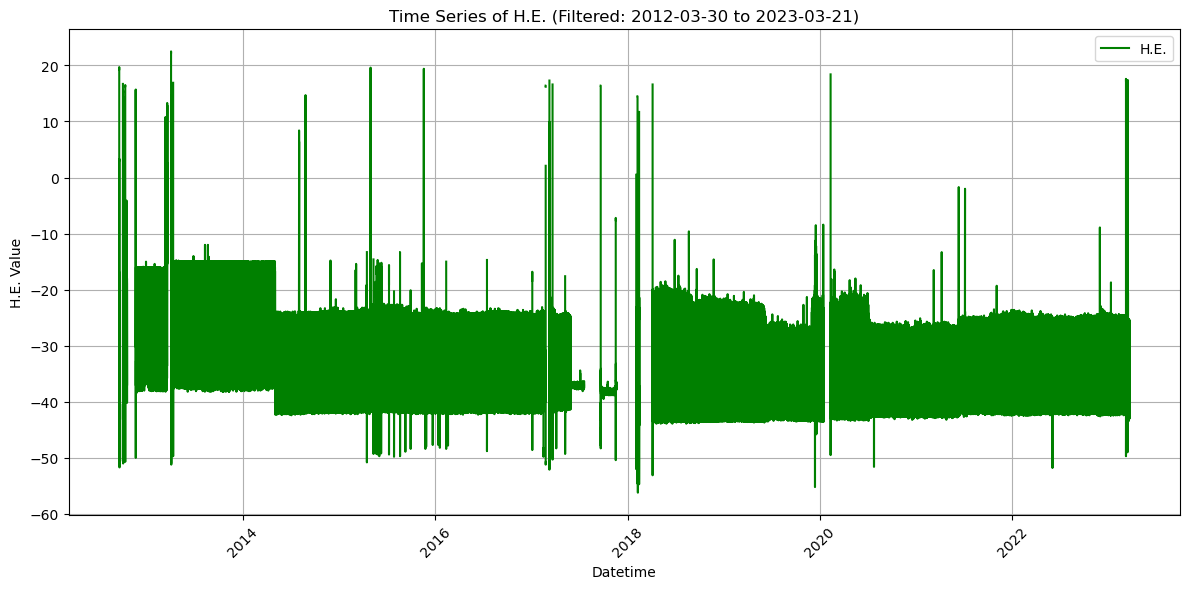

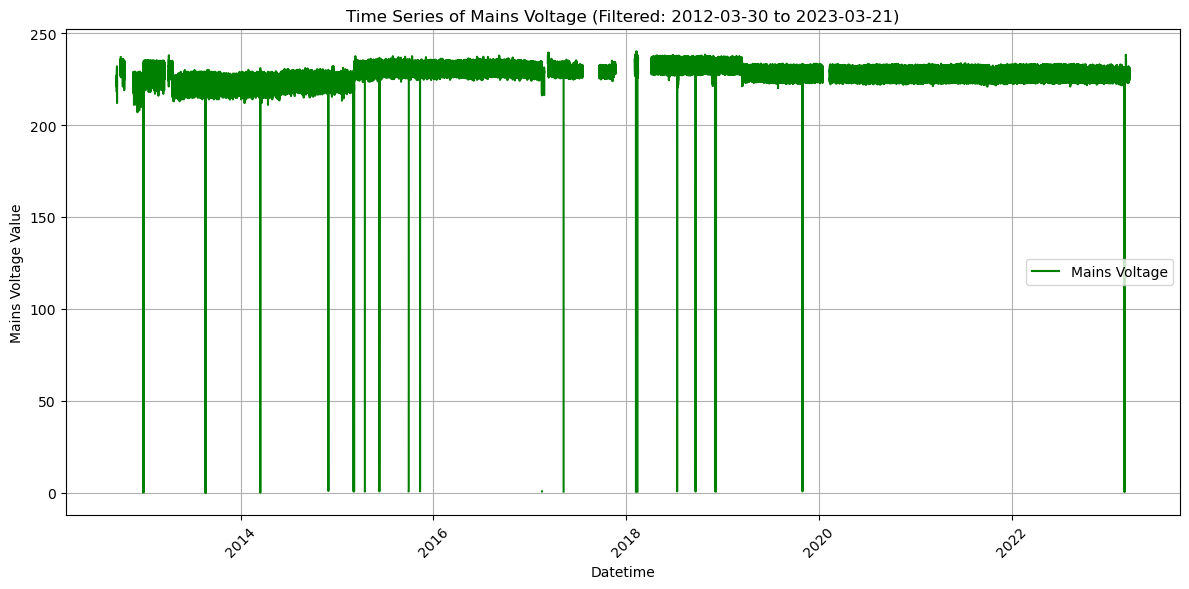

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Freezer_number = 806031

# Parameters
start_date = '2012-03-30'
end_date = '2023-03-21'

# Read the cleaned Parquet file into a DataFrame
df = pd.read_parquet(path + str(Freezer_number) + '_temp.parquet')

# Convert 'Datetime' to datetime type if it's not already
df['Datetime'] = pd.to_datetime(df['Datetime'])

# Set 'Datetime' as the index for easier plotting
df.set_index('Datetime', inplace=True)

# Filter the DataFrame to the specified date range
df_filtered = df.loc[start_date:end_date]

# Select only numeric columns for plotting
numeric_columns = df_filtered.select_dtypes(include=['float64', 'int64']).columns

# Calculate time differences between consecutive rows
time_diffs = df_filtered.index.to_series().diff().dt.total_seconds()

# Define a threshold (e.g., 2x the median difference) to detect large gaps
gap_threshold = 2 * time_diffs.median()

# Insert NaNs where gaps are detected
df_filtered.loc[time_diffs > gap_threshold, numeric_columns] = np.nan

# Plot each numeric column separately
for col in numeric_columns:
    plt.figure(figsize=(12, 6))
    plt.plot(df_filtered.index, df_filtered[col], label=col, color='green')
    
    plt.title(f"Time Series of {col} (Filtered: {start_date} to {end_date})")
    plt.xlabel("Datetime")
    plt.ylabel(f"{col} Value")
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.legend()
    plt.show()